<a href="https://colab.research.google.com/github/CeciASanz/NLP/blob/main/Ejercicio%202/2b%20-%20bot_dnn_spacy_esp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pipeline NLP transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 11.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fiona 1.9.4.post1 requires click~=8.0, but you have click 7.1.2 which is incompatible.
flask 2.2.5 requires click>=8.0, but you have click 7.1.2 which is incompatible.
dask 2023.8.0 requires click>=8.0, but you have click 7.1.2 which is incompatible.
distributed 2023.8.0 requires click>=8.0, but you have click 7.1.2 which is incompatible.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.1.0 which is incompatible.
inflect 7.0.0 requires pydantic>=1.9.1, but you 

In [2]:
import json
import string
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [3]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish)...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [25]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [21]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

AttributeError: ignored

In [24]:
# Ejemplo de como funciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokens = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokens)
print("Lematización de cada token:")
for token in tokens:
    print([token, token.lemma_], token.is_stop)


tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar'] False
[personas, 'persona'] False
[ideas, 'idea'] False
[estas, 'este'] True
[cosas, 'cosa'] True
[y, 'y'] False
[los, 'el'] True
[peces, 'pez'] False
[y, 'y'] False
[los, 'el'] True
[murcielagos, 'murcielago'] False


### 3 - Diccionario de entrada

In [7]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?"],
              "responses": ["Mi nombre es Ayla Pilates", "Somos Ayla Pilates"]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Podes contactarnos al siguiente <numero>", "Contactos al whatsapp <numero>"]
             },
            {"tag": "clases",
              "patterns": ["¿Cuanto duran las clases?", "¿Cuantas personas por clase?"],
              "responses": ["Las clases duran 50 minutos son de hasta 7 alumnos por clase."]
             },
            {"tag": "horarios",
              "patterns": ["horarios", "Me podrás pasar los horarios", "¿En que horario?", "¿Que días?"],
              "responses": ["Lunes, miércoles y viernes de 8 a 15hs, martes y jueves de 8 a 13hs y de lunes a viernes de 16 a 21hs"]
             },
            {"tag": "precio",
              "patterns": ["precios", "Me podrás pasar los precios", "¿Cual es el precio?"],
              "responses": ["1 vez por semana $6200, 2 veces por semana $7400, 3 veces por semana $8200, 4 veces por semana $9400"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
              "responses": ["Podes pagarnos en efectivo o con Mercafo Pago"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [29]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens si no son stop words
        for token in tokens:
          if not token.is_stop:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [30]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['chau', 'clase', 'contacto', 'credito', 'cuota', 'durar', 'gracias', 'holar', 'horario', 'medio', 'nombre', 'numero', 'pago', 'pasar', 'persona', 'poder', 'precio', 'ser', 'tarjeta', 'telefono', 'whatsapp']
classes: ['agradecimientos', 'bienvenida', 'clases', 'contacto', 'despedida', 'horarios', 'nombre', 'pagos', 'precio']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', 'contacto', 'número de contacto', 'número de teléfono', 'número de whatsapp', 'whatsapp', '¿Cuanto duran las clases?', '¿Cuantas personas por clase?', 'horarios', 'Me podrás pasar los horarios', '¿En que horario?', '¿Que días?', 'precios', 'Me podrás pasar los precios', '¿Cual es el precio?', 'medios de pago', 'tarjeta de crédito', 'tarjetas', 'cuotas', 'Muchas gracias', 'Gracias', 'Chau', 'Hasta luego!']
doc_y: ['bienvenida', 'bienvenida', 'bienvenida', 'nombre', 'nombre', 'contacto', 'contacto', 'contacto', 'contacto', 'contacto', 'clases', 'clases', 'horarios', 'horarios', 

In [31]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 21


In [32]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 9


In [33]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 1, 0, 0, 0, 0, 0]
X: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 1, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0] y: [0, 0, 0, 1, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 0, 1, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 0, 1, 0, 0, 0, 0, 0]
X: [0, 1, 0, 0, 0, 1

### 5 - Entrenamiento del modelo

In [34]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (21,) output: 9


In [35]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               2816      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 9)                 585       
                                                                 
Total params: 11,657
Trainable params: 11,657
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 2.2257 - accuracy: 0.1111
Epoch 2/200
1/1 [==============================] - 0s 10ms/step - loss: 2.1998 - accuracy: 0.1481
Epoch 3/200
1/1 [==============================] - 0s 9ms/step - loss: 2.1508 - accuracy: 0.1852
Epoch 4/200
1/1 [==============================] - 0s 7ms/step - loss: 2.1881 - accuracy: 0.1481
Epoch 5/200
1/1 [==============================] - 0s 7ms/step - loss: 2.1372 - accuracy: 0.1852
Epoch 6/200
1/1 [==============================] - 0s 10ms/step - loss: 2.1520 - accuracy: 0.1852
Epoch 7/200
1/1 [==============================] - 0s 7ms/step - loss: 2.1889 - accuracy: 0.1111
Epoch 8/200
1/1 [==============================] - 0s 7ms/step - loss: 2.1427 - accuracy: 0.2222
Epoch 9/200
1/1 [==============================] - 0s 6ms/step - loss: 2.0948 - accuracy: 0.1852
Epoch 10/200
1/1 [==============================] - 0s 7ms/step - loss: 2.1391 - accuracy: 0.1111
Epoch 11/200
1/1 [==========

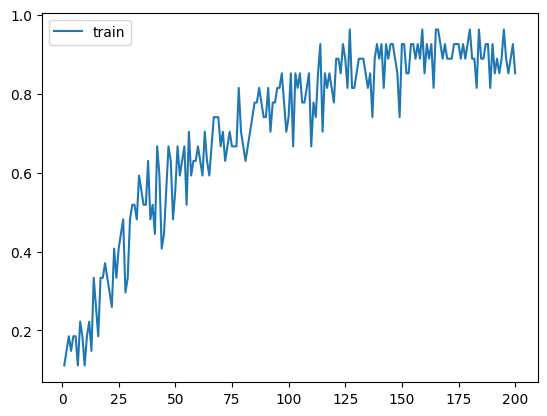

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [38]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [39]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)

        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents:
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria
            result = random.choice(i["responses"])
            break
    return result

In [40]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")


hola
Q: hola
1/1 [==============================] - 0s 45ms/step
BOT: Hola!
clases
Q: clases
1/1 [==============================] - 0s 15ms/step
BOT: Las clases duran 50 minutos son de hasta 7 alumnos por clase.
horarios
Q: horarios
1/1 [==============================] - 0s 14ms/step
BOT: Lunes, miércoles y viernes de 8 a 15hs, martes y jueves de 8 a 13hs y de lunes a viernes de 16 a 21hs
en que horario son las clases
Q: en que horario son las clases
1/1 [==============================] - 0s 27ms/step
BOT: Lunes, miércoles y viernes de 8 a 15hs, martes y jueves de 8 a 13hs y de lunes a viernes de 16 a 21hs
cual es el precio?
Q: cual es el precio?
1/1 [==============================] - 0s 18ms/step
BOT: 1 vez por semana $6200, 2 veces por semana $7400, 3 veces por semana $8200, 4 veces por semana $9400
cual es el valor?
Q: cual es el valor?
1/1 [==============================] - 0s 20ms/step
BOT: Somos Ayla Pilates
cual es el valor de las clases?
Q: cual es el valor de las clases?
1/1 [

KeyboardInterrupt: ignored

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words

Se modifico el diccionario de entrada

### Alumno

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

### Cambios realizados


*   Se modifico el diccionario de entrada
*   Se filtraron las stop words



### Conclusiones


*   El accuracy del entrenamiento fue levemente mejor con las stop words incluidas
*   El modelo entrenado con stop words responde mejor ante preguntas con palabras no incluidas en el diccionario
